## Imports

In [31]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import accuracy_score
import random

from codecarbon import track_emissions


In [38]:
seed =42
# Set the seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed)
generator = torch.Generator().manual_seed(seed)

## Preprocessing

In [2]:
df = pd.read_excel('..//HeartFailure.xlsx')
df.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
for col in df.columns:
    if df[col].dtypes =='O':
        df[col] = pd.Categorical(df[col]).codes

df.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0


In [4]:
print(df['HeartDisease'].value_counts())

1    508
0    410
Name: HeartDisease, dtype: int64


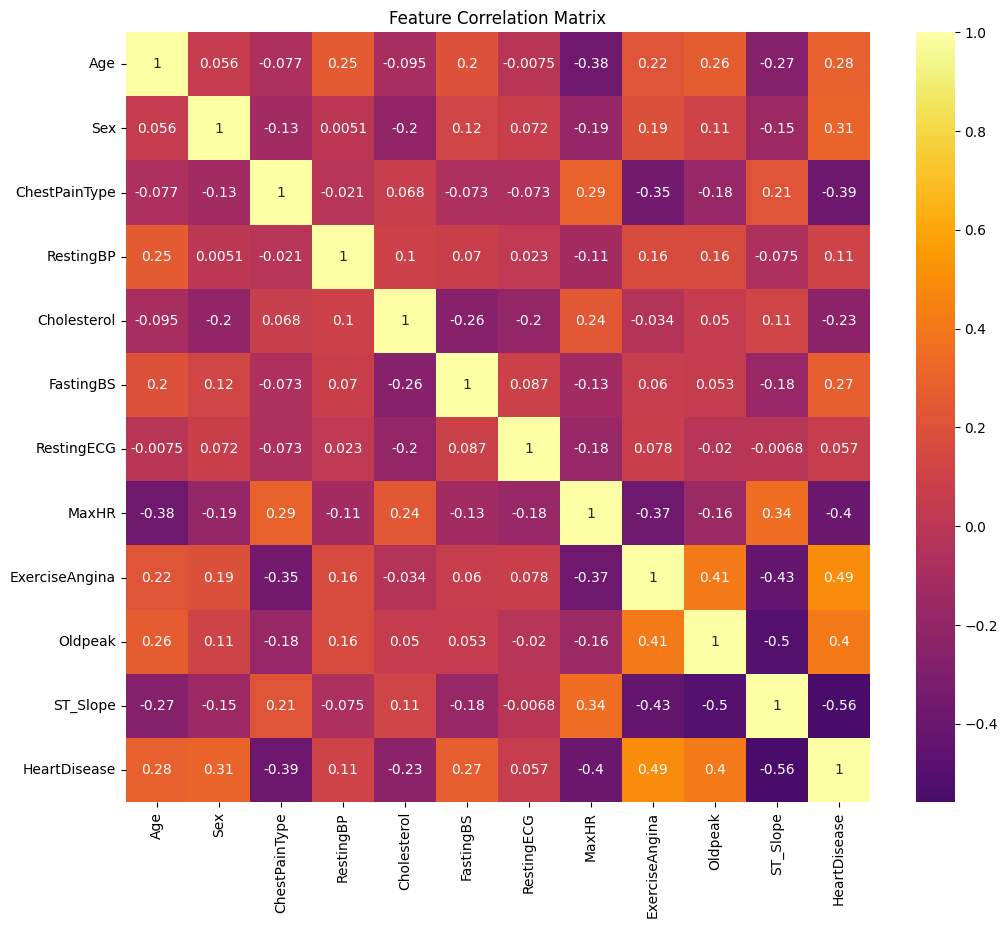

In [5]:
corr_matrix = df.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='inferno', center=0)
plt.title('Feature Correlation Matrix')
plt.show()



#### Standardize

In [6]:
# Select the columns to be standardized
columns_to_standardize = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

# Create a StandardScaler object
scaler = StandardScaler()

# Standardize the selected columns
df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

#### Dataset Split

In [7]:
#Split the dataset into training and testing sets
X = df.drop('HeartDisease', axis=1).values
y = df['HeartDisease'].values

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Split data into training and test sets
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size],generator=generator)

### Shallow MLP

#### Params

In [20]:
hidden_layer_dim = 64
num_epochs = 50
batch_size = 32
lr = 0.001
input_size = X.shape[1]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [9]:
grid = {
        num_epochs: [50, 100],
        hidden_layer_dim: [16,32,64,128],
        batch_size: [16,32,64],
        lr: [0.001, 0.01, 0.1],
        }

#### Shallow MLP

In [39]:
# Define the simplest MLP model
class SimpleMLP(nn.Module):
    def __init__(self, input_size):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_layer_dim)  # Hidden layer with 10 units
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_layer_dim, 1)  # Output layer with 1 unit for binary classification
        self.sigmoid = nn.Sigmoid()
        
        torch.manual_seed(seed) 
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Function to train the model
#@track_emissions
def train_model(model, train_loader, criterion, optimizer, num_epochs, printing = True):
    model.train()
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        if printing:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

# Function to evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Test Accuracy: {accuracy:.4f}')
    return accuracy
    


#### Single train

In [40]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, generator=generator)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,generator=generator)

In [43]:


# Initialize model, criterion, and optimizer
model = SimpleMLP(input_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train and evaluate the model
train_model(model, train_loader, criterion, optimizer, num_epochs)
test_acc = evaluate_model(model, test_loader)
print(test_acc)

Epoch 1/50, Loss: 0.5941
Epoch 2/50, Loss: 0.5093
Epoch 3/50, Loss: 0.4511
Epoch 4/50, Loss: 0.4115
Epoch 5/50, Loss: 0.3858
Epoch 6/50, Loss: 0.3674
Epoch 7/50, Loss: 0.3528
Epoch 8/50, Loss: 0.3399
Epoch 9/50, Loss: 0.3286
Epoch 10/50, Loss: 0.3192
Epoch 11/50, Loss: 0.3111
Epoch 12/50, Loss: 0.3039
Epoch 13/50, Loss: 0.2970
Epoch 14/50, Loss: 0.2909
Epoch 15/50, Loss: 0.2855
Epoch 16/50, Loss: 0.2809
Epoch 17/50, Loss: 0.2765
Epoch 18/50, Loss: 0.2725
Epoch 19/50, Loss: 0.2686
Epoch 20/50, Loss: 0.2650
Epoch 21/50, Loss: 0.2617
Epoch 22/50, Loss: 0.2583
Epoch 23/50, Loss: 0.2551
Epoch 24/50, Loss: 0.2518
Epoch 25/50, Loss: 0.2489
Epoch 26/50, Loss: 0.2460
Epoch 27/50, Loss: 0.2433
Epoch 28/50, Loss: 0.2407
Epoch 29/50, Loss: 0.2382
Epoch 30/50, Loss: 0.2359
Epoch 31/50, Loss: 0.2338
Epoch 32/50, Loss: 0.2316
Epoch 33/50, Loss: 0.2297
Epoch 34/50, Loss: 0.2276
Epoch 35/50, Loss: 0.2258
Epoch 36/50, Loss: 0.2242
Epoch 37/50, Loss: 0.2226
Epoch 38/50, Loss: 0.2211
Epoch 39/50, Loss: 0.

#### Grid search

In [12]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, criterion, and optimizer
model = SimpleMLP(input_size)
criterion = nn.BCELoss()

for hyperparam in grid:
    
    
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train and evaluate the model
train_model(model, train_loader, criterion, optimizer, num_epochs)
evaluate_model(model, test_loader)

IndentationError: expected an indented block (1678774262.py, line 12)